# **Importing libraries.**
About Dataset
Sales Prediction for Big Mart Outlets
> The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.*

**after that we are going to try to understand the key features to an increase in the sales.**

In [1]:
!pip install --quiet pycaret

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pycaret.regression import RegressionExperiment

**Loading data and performing a quick EDA**

In [2]:
train = pd.read_csv('/kaggle/input/big-mart-sales-prediction-datasets/train.csv')
test = pd.read_csv('/kaggle/input/big-mart-sales-prediction-datasets/test.csv')

print(train.isna().sum(),'\n\n',
      test.isna().sum())
train.head()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64 

 Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
# looping through categorical features and printing their unique values to decide whether we should encode them or no
for column in train.columns:
    if train[column].dtype == 'object':
        print(f'{column} has {len(train[column].unique())} unique values.')

Item_Identifier has 1559 unique values.
Item_Fat_Content has 5 unique values.
Item_Type has 16 unique values.
Outlet_Identifier has 10 unique values.
Outlet_Size has 4 unique values.
Outlet_Location_Type has 3 unique values.
Outlet_Type has 4 unique values.


In [4]:
print('Outlet type unique values: ',train.Outlet_Type.unique(),'\n')
print('Item type unique values: ',train.Item_Type.unique(),'\n')

train.duplicated().sum()

Outlet type unique values:  ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3'] 

Item type unique values:  ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood'] 



0

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  


<Axes: >

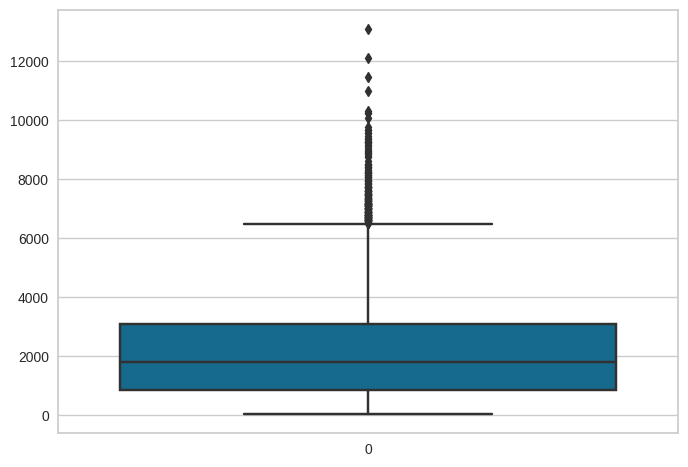

In [5]:
# detecting outliers
print(train.describe())
sns.boxplot(train.Item_Outlet_Sales)

In [6]:
print((np.where(train['Item_Outlet_Sales']>7500)))
print((train.Item_Outlet_Sales > 7500).sum())

(array([ 130,  304,  333,  373,  456,  472,  753,  809,  991,  997, 1009,
       1254, 1450, 1506, 1859, 1998, 2109, 2216, 2293, 2516, 2535, 2776,
       3083, 3087, 3098, 3154, 3234, 3286, 3709, 3720, 3757, 4289, 4346,
       4349, 4676, 4681, 4772, 4888, 4961, 4991, 5065, 5177, 5185, 5223,
       5315, 5500, 5550, 5619, 5752, 5977, 6134, 6334, 6409, 6537, 6541,
       6606, 6886, 6993, 7016, 7076, 7188, 7191, 7236, 7256, 7302, 7343,
       7562, 7690, 7752, 7816, 7826, 7930, 8039, 8201, 8245, 8447]),)
76


In [7]:
le = LabelEncoder()
scaler = MinMaxScaler()
cols = ['Item_Weight', 'Item_Visibility','Item_MRP']

def preprocessing(df):
    
    # dropping features that has no use in our training
    df = df.drop(['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'],axis=1)
    
    # dealing with null values
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace = True)
    df = df.dropna(axis = 0)
    
    # encoding categorical data
    df['Outlet_Size'] = df['Outlet_Size'].map({'Small':0, 'Medium':1, 'High':2})
    df = df.apply(lambda x: le.fit_transform(x) if x.dtype == 'object' else x)
    
    # dealing with outliers
#     q = df['Item_Outlet_Sales'].quantile(0.99)
#     df = df[df['Item_Outlet_Sales'] < q]
    
    # normalizing data
    for column in cols:
        
        column_data = df[column].values.reshape(-1, 1)
        column_scaled = scaler.fit_transform(column_data)
        df[column] = column_scaled
        
        
    return df

In [8]:
cleandf = preprocessing(train)

print('old shape',train.shape)
print('new shape',cleandf.shape)
cleandf.sample(10)

old shape (8523, 12)
new shape (6113, 9)


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
353,0.203334,1,0.104914,14,0.605913,0,0,1,2586.6330
2981,0.761834,2,0.191357,0,0.252943,0,1,1,1707.7770
2708,0.681453,1,0.301827,9,0.761891,0,1,1,4460.1942
777,0.053885,2,0.097967,3,0.651677,0,1,1,4287.7520
76,0.493897,1,0.101193,13,0.598698,1,0,1,1207.0954
4843,0.821375,1,0.270740,9,0.685745,2,2,1,2876.2560
7899,0.045847,2,0.424022,4,0.092275,1,2,2,377.5086
3735,0.979160,1,0.150753,13,0.696345,1,2,2,1162.4868
7592,0.494352,1,0.105721,3,0.628801,1,2,3,6066.7696
3633,0.020840,1,0.357221,3,0.698166,0,1,1,2956.1520


# **Building the model.**
PyCaret offers tools to compare multiple models, helping you identify the best-performing one for your dataset. Additionally, it provides interpretability features to understand how models make predictions, enhancing trust and transparency in your model's results.

In [9]:
# splitting our train dataframe for training
shuffle_df = cleandf.sample(frac=1)
train_size = int(0.8 * len(cleandf))

train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:]

In [10]:
exp = RegressionExperiment()
exp.setup(train_set, test_data = test_set, target = 'Item_Outlet_Sales', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Item_Outlet_Sales
2,Target type,Regression
3,Original data shape,"(6113, 9)"
4,Transformed data shape,"(6113, 9)"
5,Transformed train set shape,"(4890, 9)"
6,Transformed test set shape,"(1223, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [11]:
exp.compare_models(fold = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,808.3502,1297839.6554,1138.9208,0.5765,0.5555,0.5737,0.2920
catboost,CatBoost Regressor,836.7864,1399808.9527,1182.8590,0.5430,0.5746,0.5827,1.8220
lightgbm,Light Gradient Boosting Machine,834.4091,1401796.2566,1183.6209,0.5425,0.5627,0.5878,0.3820
rf,Random Forest Regressor,847.8998,1432259.4140,1196.6496,0.5323,0.5585,0.5803,0.6060
et,Extra Trees Regressor,857.1371,1479514.1720,1216.2687,0.5168,0.5654,0.5842,0.4000
br,Bayesian Ridge,940.6865,1552241.1500,1245.5982,0.4940,0.7398,0.9095,0.0240
llar,Lasso Least Angle Regression,940.4889,1552164.5250,1245.5688,0.4940,0.7325,0.9087,0.0240
lar,Least Angle Regression,940.7889,1552238.6000,1245.5968,0.4940,0.7400,0.9102,0.0240
lr,Linear Regression,940.7888,1552238.5250,1245.5968,0.4940,0.7400,0.9102,0.5760
lasso,Lasso Regression,940.4882,1552165.0000,1245.5689,0.4940,0.7325,0.9087,0.0240


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

GradientBoostingRegressor(random_state=123)

*apparantly Gradient boosting regressor(GBR) fits our data the best, among those other algorithms so we're going to stick to it and use it in our advantage.*

In [12]:
# creating an instance of the model.
model = exp.create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,781.1819,1150071.5642,1072.4139,0.6195,0.5465,0.5391
1,795.0583,1238904.2749,1113.0608,0.6039,0.5206,0.5190
2,822.3442,1320498.7536,1149.1296,0.5737,0.5460,0.5658
3,811.6468,1274390.1164,1128.8889,0.6144,0.5694,0.6117
4,779.4502,1173245.6962,1083.1647,0.5860,0.5424,0.5514
5,836.8595,1492857.9614,1221.8257,0.5367,0.5636,0.5741
6,762.6207,1184053.5201,1088.1422,0.5346,0.5594,0.5899
7,809.3460,1358026.8243,1165.3441,0.5366,0.5400,0.5368
8,814.9737,1323397.9266,1150.3903,0.6021,0.5920,0.6390


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

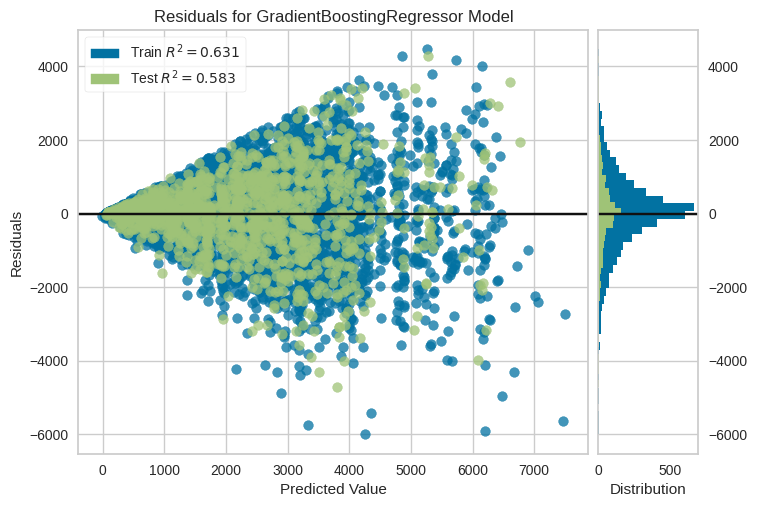

In [13]:
exp.plot_model(model, plot = 'residuals')

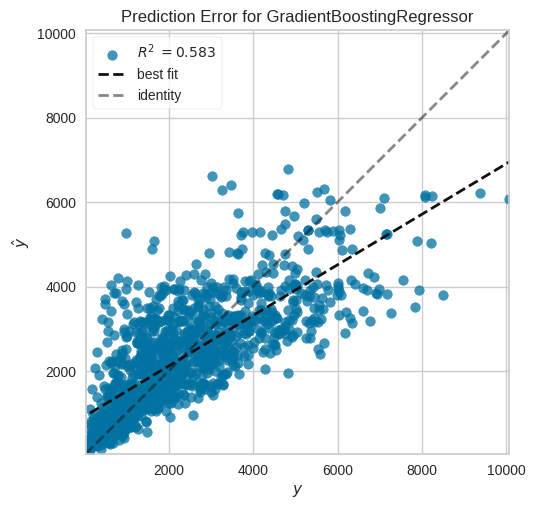

In [14]:
# plot error
exp.plot_model(model, plot = 'error')

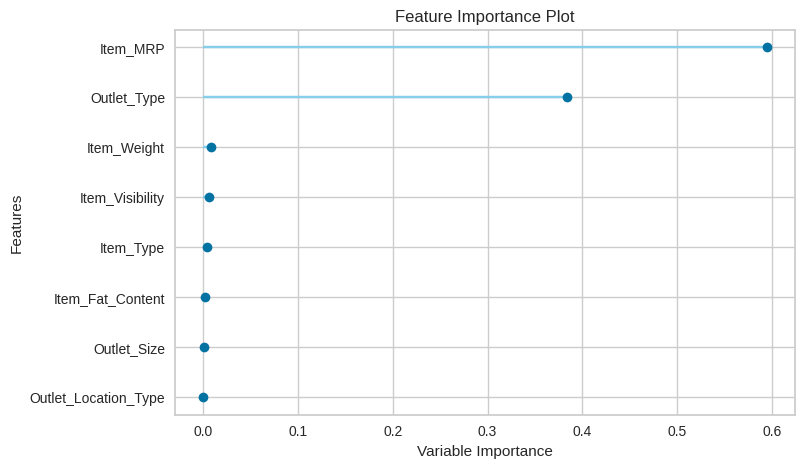

In [15]:
exp.plot_model(model, plot = 'feature') # feature importance

# Our top 3 most effective features in sales increase are:
1. Item MRP: Maximum Retail Price (list price) of the product.
2. Outlet type: Whether the outlet is just a grocery store or some sort of supermarket.
3. The % of the total display area of all products in a store allocated to the particular product.

In [16]:
# labeling this test set using our trained model since they included it in the data card
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [17]:
# running our test data through the preprocessing function
preprocessed_test = preprocessing(test)

# Using the best model to predict labels for our test set.
pred = exp.predict_model(model, data = preprocessed_test) 
pred.head(10)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,prediction_label
0,0.964275,1,0.023374,13,0.323413,1,0,1,1665.836512
4,0.484706,2,0.366458,4,0.862069,1,2,3,6227.917091
5,0.312295,2,0.197187,6,0.363000,0,0,1,1898.006609
6,0.880917,2,0.255229,0,0.077210,1,2,2,601.900140
7,0.484706,1,0.048766,0,0.209163,1,2,3,2178.721223
12,0.484706,1,0.528614,8,0.888453,0,0,0,651.594718
13,0.013695,1,0.286548,1,0.384998,1,0,1,2218.185908
14,0.726109,0,0.065525,7,0.085422,2,2,1,817.315936
15,0.094076,2,0.245493,0,0.510006,1,0,1,2404.423413
17,0.791605,1,0.117357,14,0.682992,1,2,2,2958.605533
